In [1]:
!git clone https://github.com/Leejunho123/deep-learning-from-scratch-3.git
%cd /content/deep-learning-from-scratch-3

Cloning into 'deep-learning-from-scratch-3'...
remote: Enumerating objects: 2097, done.
remote: Total 2097 (delta 0), reused 0 (delta 0), pack-reused 2097
Receiving objects: 100% (2097/2097), 32.30 MiB | 35.29 MiB/s, done.
Resolving deltas: 100% (1444/1444), done.
/content/deep-learning-from-scratch-3


In [1]:
!git clone https://github.com/Leejunho123/5G_project.git
%cd /content/5G_project/DeepLearning

Cloning into '5G_project'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 11552 (delta 55), reused 50 (delta 28), pack-reused 11474
Receiving objects: 100% (11552/11552), 245.95 MiB | 30.43 MiB/s, done.
Resolving deltas: 100% (2932/2932), done.
Checking out files: 100% (250/250), done.
/content/5G_project/DeepLearning


## 50 미니 배치를 뽑아주는 DataLoader


### 50.1 반복자란

In [1]:
t = [1,2,3]
x = iter(t)
next(x)


1

In [2]:
next(x)

2

In [3]:
next(x)

3

In [4]:
next(x)

StopIteration: ignored

In [6]:
class MyIterator:
  def __init__(self, max_cnt):
    self.max_cnt = max_cnt
    self.cnt = 0

  def __iter__(self):
    return self

  def __next__(self):
    if self.cnt == self.max_cnt:
      raise StopIteration

    self.cnt += 1
    return self.cnt



In [7]:
obj = MyIterator(5)
for x in obj:
  print(x)

1
2
3
4
5


In [8]:
import math
import random
import numpy as np

class DataLoader:
  def __init__(self, dataset, batch_size, shuffle = True):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.data_size = len(dataset)
    self.max_iter = math.ceil(self.data_size / batch_size)

    self.reset()

  def resert(self):
    self.iteration = 0
    if self.shuffle:
      self.index = np.random.permutation(len(self.dataset))

    else:
      self.index = np.arange(len(self.dataset))

  def __iter__(self):
    return self

  def __next__(self):
    if self.iteration >= self.max_iter:
      self.reset()

      raise StopIteration

    i , batch_size = self.iteration, self.batch_size
    batch_index = self.index[i * batch_size:(i+1)*batch_size]
    batch = [self.dataset[i] for i in batch_index]
    x = np.array([example[0] for example in batch])
    t = np.array([example[1] for example in batch])

    self.iteration += 1
    return x, t

  def next(self):
    return self.__next__()



### 50.2 DataLoader 사용하기

In [2]:
from dezero.datasets import Spiral
from dezero import DataLoader

In [3]:
batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
  for x , t in train_loader:
    print(x.shape, t.shape)
    break

  for x,t in test_loader:
    print(x.shape, t.shape)
    break

(10, 2) (10,)
(10, 2) (10,)


### 50.3 accuracy 함수 구현하기 

In [4]:
def accuracy(y, t):
  y, t = as_variable(y), as_variable(t)
  pred = y.data.argmax(axis=1).reshape(t.shape)
  result = (pred == t.data)
  acc = result.mean()

  return Variable(as_array(acc))
  

In [2]:
import numpy as np
import dezero.functions as F

y = np.array([[0.2,0.8,0],[0.1,0.9,0],[0.8,0.1,0.1]])
t = np.array([1,2,0])
acc = F.accuracy(y,t)
print(acc)

variable(0.6666666666666666)


### 50.4 스파이럴 데이터셋 학습 코드

In [4]:
import dezero
from dezero import DataLoader
from dezero.models import MLP
from dezero import optimizers
import numpy as np
import dezero.functions as F

In [9]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle = False)
Train_Loss = []
Test_Loss = []
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
  sum_loss, sum_acc = 0,0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y,t)
    acc = F.accuracy(y,t)
    model.cleargrads()
    loss.backward()
    optimizer.update()

    sum_loss += float(loss.data) * len(t)
    sum_acc += float(acc.data) * len(t)

  print('epoch: {}'.format(epoch+1))
  print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss/len(train_set), sum_acc/len(train_set)))
  Train_Loss.append(sum_loss/len(train_set))
  sum_loss, sum_acc = 0, 0
  with dezero.no_grad():
    for x, t in test_loader:
      y = model(x)
      loss = F.softmax_cross_entropy(y,t)
      acc = F.accuracy(y,t)
      sum_loss += float(loss.data) * len(t)
      sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss/len(test_set), sum_acc/len(test_set)))
  Test_Loss.append(sum_loss/len(test_set))

epoch: 1
train loss: 1.0944, accuracy: 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch: 2
train loss: 0.9882, accuracy: 0.4933
test loss: 0.9729, accuracy: 0.4333
epoch: 3
train loss: 0.9403, accuracy: 0.5133
test loss: 0.8965, accuracy: 0.6233
epoch: 4
train loss: 0.8820, accuracy: 0.5700
test loss: 0.8771, accuracy: 0.5967
epoch: 5
train loss: 0.8617, accuracy: 0.5600
test loss: 0.8670, accuracy: 0.5867
epoch: 6
train loss: 0.8313, accuracy: 0.5300
test loss: 0.8654, accuracy: 0.6000
epoch: 7
train loss: 0.8086, accuracy: 0.5833
test loss: 0.7950, accuracy: 0.5600
epoch: 8
train loss: 0.7948, accuracy: 0.5733
test loss: 0.7921, accuracy: 0.5900
epoch: 9
train loss: 0.7728, accuracy: 0.5500
test loss: 0.7718, accuracy: 0.5300
epoch: 10
train loss: 0.7643, accuracy: 0.5633
test loss: 0.7796, accuracy: 0.5800
epoch: 11
train loss: 0.7862, accuracy: 0.5600
test loss: 0.7701, accuracy: 0.5633
epoch: 12
train loss: 0.7914, accuracy: 0.5500
test loss: 0.8218, accuracy: 0.6067
epoch: 13
tra

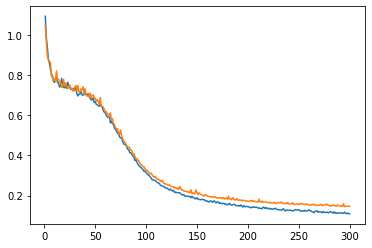

In [10]:
import matplotlib.pyplot as plt
x = np.arange(1,max_epoch+1)
plt.plot(x,Train_Loss)
plt.plot(x,Test_Loss)